In [1]:
from pocs.utils.database import PanMongo
from astropy.time import Time
import pandas as pd

from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
db = PanMongo()

### Show available collections

In [3]:
db.collections

['config',
 'current',
 'drift_align',
 'environment',
 'mount',
 'observations',
 'state',
 'weather']

### Find current value for collection

In [4]:
db.get_current('weather')

{'_id': ObjectId('58d8b587535f695281fa2676'),
 'data': {'ambient_temp_C': 25.87,
  'date': datetime.datetime(2017, 3, 27, 8, 37, 23, 932000),
  'errors': {'error_1': '0', 'error_2': '0', 'error_3': '0', 'error_4': '0'},
  'gust_condition': 'Calm',
  'internal_voltage_V': 3.0,
  'ldr_resistance_Ohm': 37.3029315960912,
  'pwm_value': 9.970674486803519,
  'rain_condition': 'Dry',
  'rain_frequency': 2560.0,
  'rain_sensor_temp_C': '33.63',
  'safe': False,
  'sky_condition': 'Very Cloudy',
  'sky_temp_C': 22.53,
  'weather_sensor_firmware_version': '5.51',
  'weather_sensor_name': 'CloudWatcher',
  'weather_sensor_serial_number': '0884',
  'wind_condition': 'Calm',
  'wind_speed_KPH': 0.0},
 'date': datetime.datetime(2017, 3, 27, 8, 37, 28, 692000),
 'type': 'weather'}

In [5]:
db.get_current('environment')

{'_id': ObjectId('58d8b570535f695281fa266e'),
 'data': {'camera_board': {'accelerometer': {'o': 0,
    'x': 0.05,
    'y': 0.01,
    'z': 0.99},
   'count': 343263,
   'humidity': 61.3,
   'power': {'camera_00': 1, 'camera_01': 1},
   'temp_00': 21.7},
  'telemetry_board': {'count': 333309,
   'current': {'cameras': 312, 'fan': 43, 'main': 328, 'mount': 0},
   'humidity': None,
   'power': {'cameras': 1, 'computer': 1, 'fan': 0, 'mount': 0, 'weather': 0},
   'temp_00': 0.0,
   'temperature': [21.56, -127.0, -127.0]}},
 'date': datetime.datetime(2017, 3, 27, 11, 26, 12, 487000),
 'type': 'environment'}

### Work with a date range (and mongo cursor)

In [6]:
cursor = db.environment.find({
    'date': {
        '$gte': Time('2017-04-10').datetime,
        '$lte': Time('2017-04-12').datetime 
    }
}) #.sort([('date', -1)])

In [7]:
print("Num records: {}".format(cursor.count()))

Num records: 163467


In [8]:
environment = {
    'telemetry_board': {
        'temp_0': list(),
        'temp_1': list(),
        'temp_2': list(),
        'temp_3': list(),
#         'humidity': list(),
        'date': list(),
    },
    'camera_board': {
        'temp_0': list(),
        'humidity': list(),
        'date': list(),
    }
}

In [9]:
for record in cursor:
    try:
        data = record['data']['telemetry_board']
        board = 'telemetry_board'
        environment[board]['temp_0'].append(data['temp_00'])
        environment[board]['temp_1'].append(data['temperature'][0])
        environment[board]['temp_2'].append(data['temperature'][1])
        environment[board]['temp_3'].append(data['temperature'][2])
#         environment[board]['humidity'].append(data['humidity'])
        environment[board]['date'].append(record['date'])
    except KeyError:
        pass
        
    try:
        data = record['data']['camera_board']
        board = 'camera_board'
        environment[board]['temp_0'].append(data['temp_00'])
        environment[board]['humidity'].append(data['humidity'])
        environment[board]['date'].append(record['date'])
    except KeyError:
        pass

In [10]:
# camera = pd.DataFrame(environment['camera_board']).set_index('date')
computer_box = pd.DataFrame(environment['telemetry_board']).set_index('date')

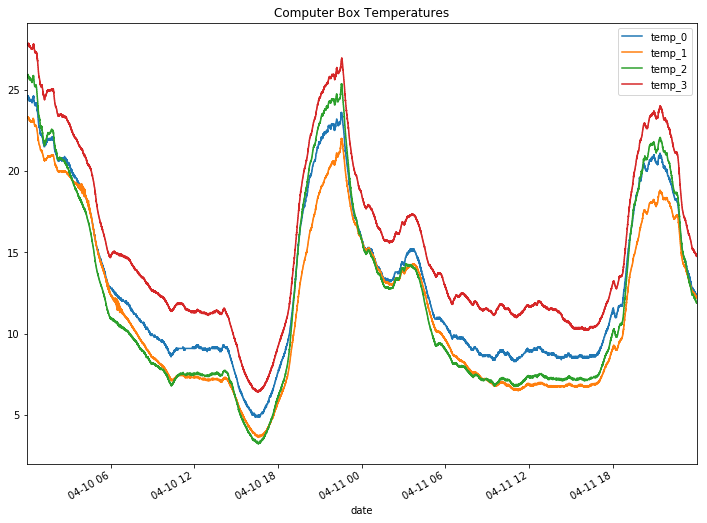

In [11]:
computer_box.plot(figsize=(12,9), title="Computer Box Temperatures")

### Work with a date range (and a list)

In [12]:
cursor = db.environment.find({
    'date': {
        '$gte': Time('2017-04-10 12:00:00').datetime,
        '$lte': Time('2017-04-10 23:59:59').datetime 
    }
}) #.sort([('date', -1)])

In [13]:
print("Num records: {}".format(cursor.count()))

Num records: 40822


In [14]:
# Convert to list
records = list(cursor)

In [15]:
# Examine first record
records[0]

{'_id': ObjectId('58eb73c1ba6c190d5c50e6b4'),
 'data': {'telemetry_board': {'count': 1047161108,
   'current': {'cameras': 507, 'fan': 45, 'main': 548, 'mount': 148},
   'date': '2017-04-10T12:00:01 GMT',
   'humidity': 1.8,
   'name': 'telemetry_board',
   'power': {'cameras': 1, 'computer': 1, 'fan': 1, 'mount': 1, 'weather': 1},
   'temp_00': 9.1,
   'temperature': [7.31, 7.56, 11.31]}},
 'date': datetime.datetime(2017, 4, 10, 12, 0, 1, 987000),
 'type': 'environment'}

In [16]:
def get_power_reading(records, key):
    # Get the timestamps
    ts = pd.Series([rec['date'] for rec in records])
    
    power = pd.Series(
        [
            rec['data']['telemetry_board']['power'][key] 
            if 'telemetry_board' in rec['data'] else None
            for rec in records 
        ],
        index=ts
    )

    if key == 'computer':
        key = 'main'
    current = pd.Series(
        [
            rec['data']['telemetry_board']['current'][key]
            if 'telemetry_board' in rec['data'] else None
            for rec in records 
        ],
        index=ts
    )
    
    
    return pd.DataFrame({'current': current, 'power': power}, index=ts).dropna()

In [17]:
df0 = get_power_reading(records, 'computer')

In [18]:
df0.head(15)

,current,power
2017-04-10 12:00:01.987,548.0,1.0
2017-04-10 12:00:04.004,542.0,1.0
2017-04-10 12:00:06.017,789.0,1.0
2017-04-10 12:00:07.029,557.0,1.0
2017-04-10 12:00:09.043,615.0,1.0
2017-04-10 12:00:12.062,560.0,1.0
2017-04-10 12:00:14.083,514.0,1.0
2017-04-10 12:00:16.092,687.0,1.0
2017-04-10 12:00:18.101,736.0,1.0
2017-04-10 12:00:20.118,705.0,1.0


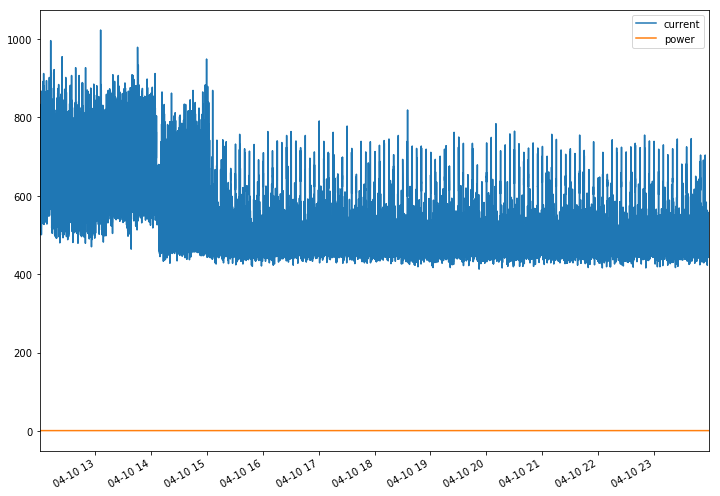

In [19]:
df0.plot(figsize=(12,9))

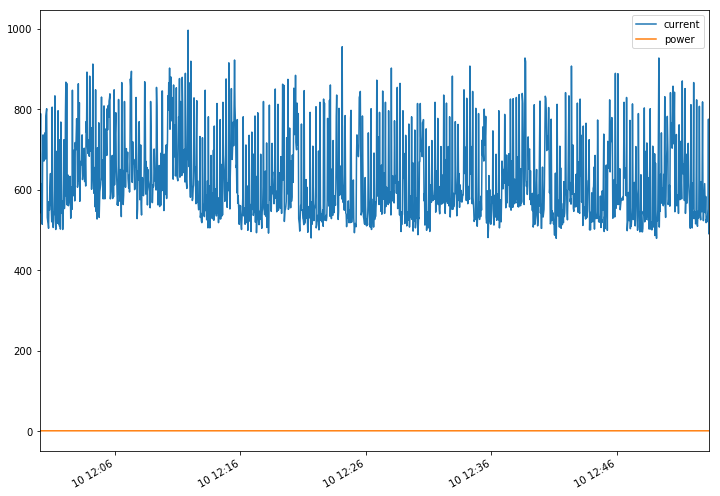

In [20]:
# Zoom in a bit
df0[0:1500].plot(figsize=(12,9))